## **Executing the MIS algorithm on a better emulator**

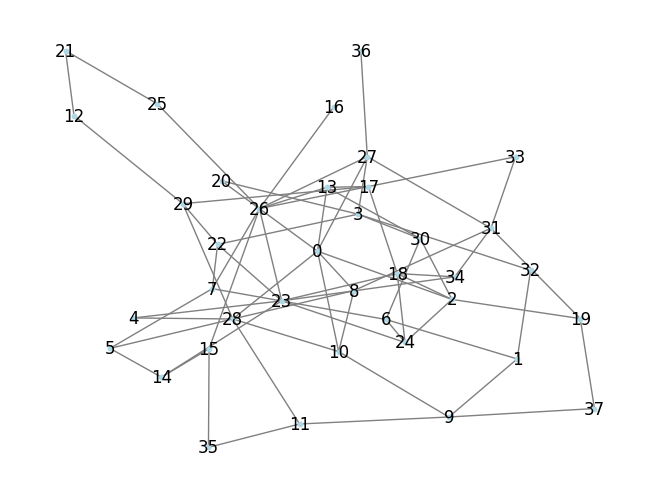

In [37]:
from QMIS_code.pulse_utils import Pulse_constructor
import networkx as nx
import matplotlib.pyplot as plt

best_pulse = Pulse_constructor(4000, "Waveform")


nb_nodes = 38
p = 0.1
graph = big_graph = nx.erdos_renyi_graph(n=nb_nodes, p=p, seed=42)
graph.add_edges_from([(21, 25), (21, 12), (25, 26)])

mapping = {node: str(node) for node in graph.nodes()}
graph = nx.relabel_nodes(graph, mapping)

pos = nx.spring_layout(graph, k=0.1, seed=42)

nx.draw(
    graph,
    with_labels=True,
    node_color="lightblue",
    node_size=10, #small nodes to see the edges
    edge_color="gray",
    pos=pos,
)
plt.show()

## Creating the sequence to emulate with this given graph

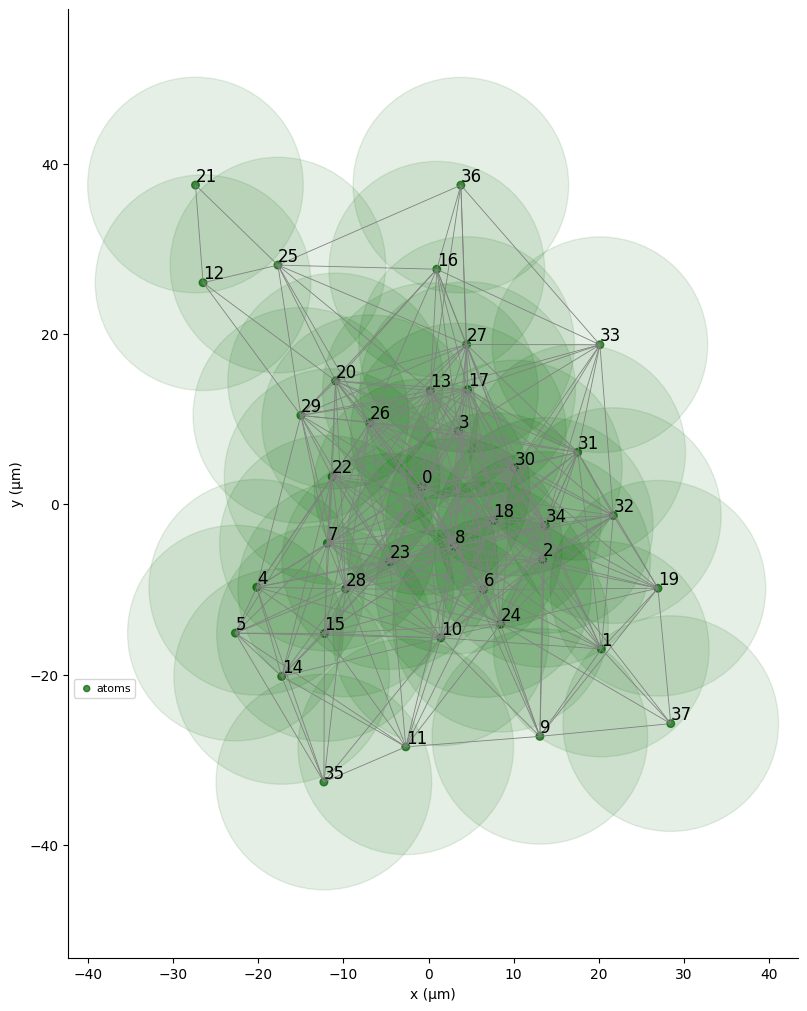

In [103]:
from pulser.devices import DigitalAnalogDevice
from pulser import Register, Sequence
from QMIS_code.QMIS_utils import find_minimal_radius
import numpy as np
from scipy.spatial.distance import pdist


R_blockade = find_minimal_radius(graph, pos)
coord = np.array(list(pos.values()))

val = np.min(pdist(coord))

min_dist = DigitalAnalogDevice.min_atom_distance
max_dist = DigitalAnalogDevice.max_radial_distance
coord *= min_dist/val
R_blockade *= min_dist/val
reg = Register.from_coordinates(coord)

reg.draw(draw_graph=True, blockade_radius=R_blockade, draw_half_radius=True)


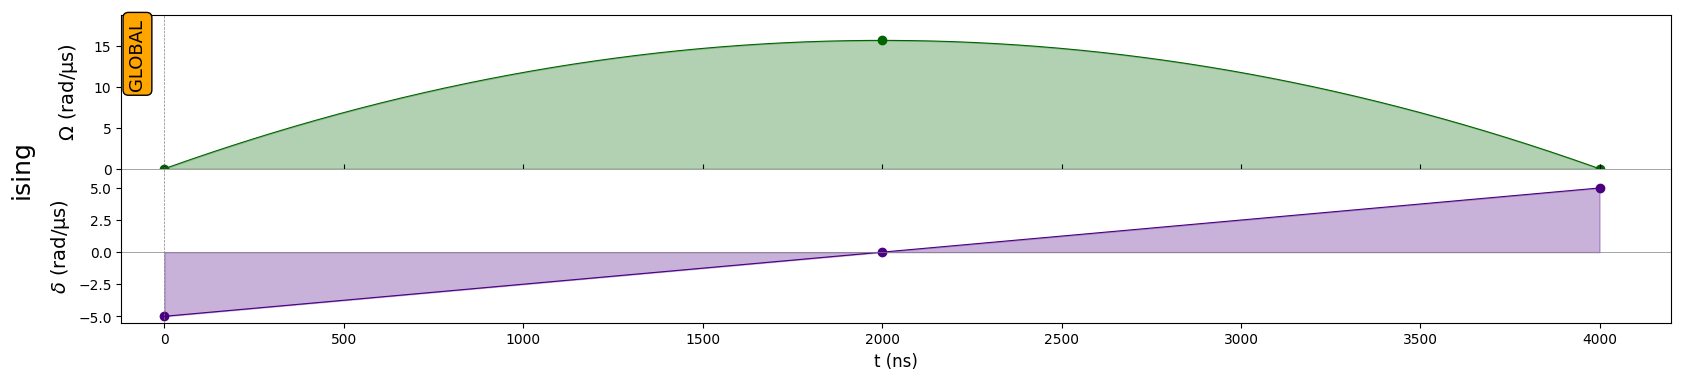

In [104]:
from QMIS_code.pulse_utils import Pulse_constructor

Omega_pulse_max = DigitalAnalogDevice.channels["rydberg_global"].max_amp
Omega = min(Omega_pulse_max-0.001, R_blockade)

seq = Sequence(reg, DigitalAnalogDevice)

pulse = Pulse_constructor(4000, "Waveform")

seq.declare_channel("ising", "rydberg_global")
seq.add(pulse(Omega), "ising")
seq.draw()

## **Running the emulation on the cloud**

In [4]:
from pulser_pasqal import PasqalCloud
from pulser.backends import EmuTNBackend
from pulser import EmulatorConfig
import dataclasses
import json

PROJECT_ID = "3e1ed7fd-69a7-42c6-b543-98e738c25b4c"
USERNAME = "Ludovic.Marcotte2@USherbrooke.ca"
PASSWORD = "AFN2hwt0vgn0vqz!afy"
connection = PasqalCloud(
        username=USERNAME, 
        project_id=PROJECT_ID,  
        password=PASSWORD, 
    )

In [106]:
#setting options of the EmuTN backend
backend_options = {'max_bond_dim' : 500} #this makes the emulator faster but limits how accurate it is
#do not go beyond 500!

#then we define the Emulator Configuration
emu_tn_config = EmulatorConfig(backend_options=backend_options, 
                               sampling_rate=0.1, 
                               evaluation_times='Final')

#we initialize the emu_tn backend, using our connection and our sequence (the same as before!)
tn_bknd = EmuTNBackend(
    seq, connection=connection, config=emu_tn_config
)



In [107]:
tn_results = tn_bknd.run([{'runs' : 100}])

/Users/ludo/anaconda3/envs/pasqal/lib/python3.11/site-packages/pulser/register/register.py:482: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


In [ ]:
batch_id = tn_results.batch_id
job_ids = tn_results.job_ids
print('batch id:', batch_id)
print('job id:', job_ids)

NameError: name 'tn_results' is not defined

In [33]:
connection._get_batch_status(batch_id="8796a6c0-ae15-461e-b42c-915524373e92")

<BatchStatus.DONE: 3>

In [40]:
try:
    results = connection._fetch_result(batch_id="8796a6c0-ae15-461e-b42c-915524373e92", job_ids=['1ba28345-6fef-4d6f-8625-602a83e20f46'])
    all_count_dicts = []
    for res in results:
        all_count_dicts.append(res.bitstring_counts)
    print(all_count_dicts)
except:
    print('job not finished running')

# #storing these results in a json file.
# with open('result.json', 'w') as fp:
#     json.dump(all_count_dicts, fp)

[{'01001010010110001000010000110010110000': 1, '00001000011010101000000000000110110101': 1, '01110001010000101000010001010101000100': 1, '10000000001000100001110001011001010111': 1, '00000000011110000100110000001001010111': 1, '10101000010110010001010000000101000111': 1, '00000000011110101101001000000000000111': 1, '01000000011110101000010000000101000101': 1, '10001000001100101100110000000000010111': 1, '10100001011110000000010000010001010110': 1, '00000000001100001000100000001000110010': 1, '00000001011110100000010000010000010110': 1, '00001000011000001001111001010001010110': 1, '11100001001100100100010001000001010110': 1, '00001000011010100000110000010010010111': 1, '00000111010000001000010001000101000110': 1, '10000100011100000001111001001000011110': 1, '00001000010000100010111111000000100111': 1, '00000000111100100000111001010010110011': 1, '00100000011100101001101001001000000100': 1, '00001000011110101011010001001100000110': 1, '00011000011100100001100001000000000110': 1, '0101100

In [41]:
best_bitstring = max(zip(all_count_dicts[0].values(), all_count_dicts[0].keys()))[1]
print("best bitstring in the histogram: ", best_bitstring)

independant_nodes = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        independant_nodes.append(str(j))

print("nodes contained in the maximal independant set: ", independant_nodes)

best bitstring in the histogram:  11100001011111100000110000000001000110
nodes contained in the maximal independant set:  ['0', '1', '2', '7', '9', '10', '11', '12', '13', '14', '20', '21', '31', '35', '36']


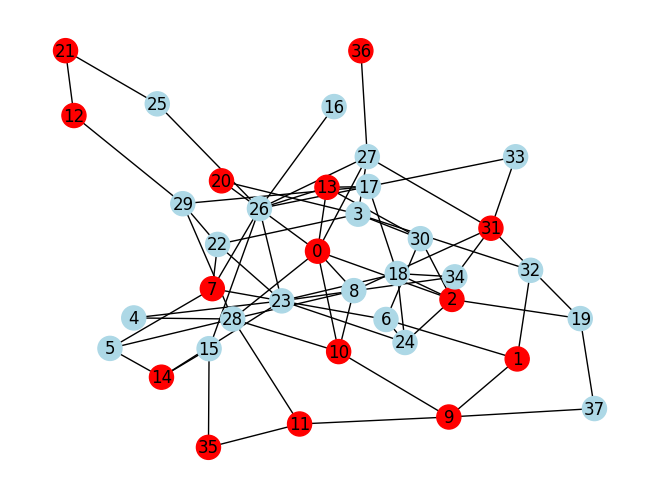

In [42]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
node_colors = ["red" if node in independant_nodes else "lightblue" for node in graph.nodes]

nx.draw(graph, pos = pos, with_labels = True, node_color = node_colors)
plt.savefig("test_mis_emuTN_39_atoms.pdf")
plt.show()


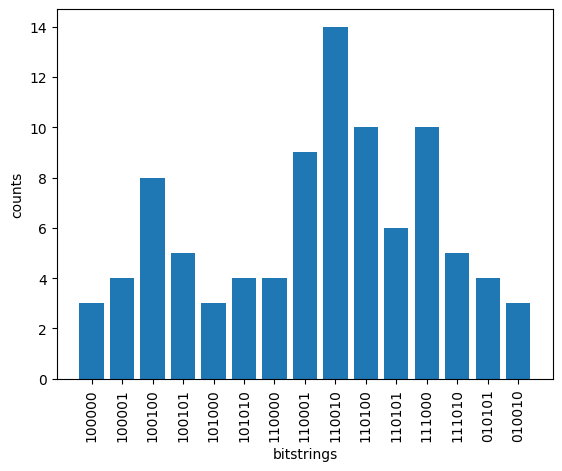

In [44]:
from QMIS_code.QMIS_utils import plot_histogram

plot_histogram({
      "100000": 3,
      "100001": 4,
      "100010": 1,
      "100100": 8,
      "100101": 5,
      "101000": 3,
      "101010": 4,
      "110000": 4,
      "110001": 9,
      "110010": 14,
      "110100": 10,
      "110101": 6,
      "111000": 10,
      "111001": 1,
      "111010": 5,
      "010101": 4,
      "010010": 3,
      "010001": 2,
      "011010": 1,
      "011000": 1,
      "000101": 1,
      "010100": 1
    }, 100)

## **Comparaison à d'autre méthodes**

In [ ]:
shots = 1000
path = "/Users/ludo/library/cloudstorage/onedrive-personnel/documents/ludovic/école/université/automne_24/bsq201/ReQpex/"

best_mis = []

### **Méthode Classique**

In [ ]:
from Find_MIS_discs import Find_MIS_discs

classical = Find_MIS_discs(graph)
res_dict = classical.run(
    shots=1000, path=path, file_name="classical_35_atoms.pdf", generate_histogram=True
)
best_mis.append(max(zip(res_dict.values(), res_dict.keys()))[1])

### **Big_QMIS**

In [ ]:
from Big_QMIS import Big_QMIS

